In [1]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py
import math
import sys

import argparse
sys.path.insert(0,'/media/DATA/jbonato/astro_segm/AstroSS/modules/')

from test_fun import *
from sel_active_reg_gen import *
from gen_single_astro  import *


from model.dense_up import dense_up





model_dict={
           'dense_up': dense_up(2)
        }


dict_param = {
    'list':[i for i in range(0,400,30)],
    'blocks':14*2,
    'threads':20,
    'BPM_ratio':2,
    'bb':40,
    'N_pix_st':25, #starting minimum area
    'astr_min':22, 
    'percentile': 90,
    'pad':5,
    'astro_num':95, # number of astro min in FOV
    'init_th_':0.5, # threshold initialization approx. 125
    'decr_dim':3, # astro area decrease
    'decr_th':12, # temporal threshold decrease
    'corr_int':True, # intensity correction flag
    'gpu_flag':True
}

In [2]:
q = [i for i in range(0,400,30)]
q

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390]

In [98]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from sklearn.externals.joblib import Parallel, delayed
from skimage.restoration import denoise_nl_means,estimate_sigma
from scipy import signal
from joblib import Parallel, delayed
import os
import h5py
from numba import cuda,float32,uint16,float64  

class ThScal():
    def __init__(self,stack):
        kernel = np.ones((50,50),np.float32)/(50*50)
        density = cv2.filter2D(np.median(stack,axis=0),-1,kernel)
        self.density = density/np.amax(density)
        
    def ThMat(self,ff,th_):
        N,M = ff.shape
        mask_th = th_*np.ones((N,M))
        
        cnt=1
        for i in [0.6,0.4,0.2,0]:
            buff = self.density.copy()
            buff[buff<i]=0
            buff[buff>=i+0.2]=0
            buff[buff>0]=1
            mask_th-=buff*(th_*0.05*cnt)
            cnt+=1

        ff[ff<mask_th]=0
        ff[ff>0]=1
        return ff,mask_th

@cuda.jit
def sel_active_gpu(T,per_mat,stack,im_out,cover,BPM_ratio,stp):
    b_dimx = cuda.blockDim.x
    b_dimy = cuda.blockDim.y
    
    bx = cuda.blockIdx.x  
    by = cuda.blockIdx.y
            
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    for bz in range(T):
        if stack[bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz,bx//BPM_ratio,by//BPM_ratio]:
            cuda.atomic.add(im_out,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)
   
        cuda.atomic.add(cover,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)


class sel_active_reg():
    
    def __init__(self,stack,dict_params,verbose=True,static=False):
        self.stack = stack
        self.step_list = dict_params['list']
        if len(self.step_list)==1:
            self.stp=1
        else:
            self.stp = self.step_list[1]-self.step_list[0]
        self.blocks = dict_params['blocks']
        self.threads = dict_params['threads']
        self.BPM_ratio = dict_params['BPM_ratio'] # # of block inside a patch
        self.bb = dict_params['bb']

        self.N_pix_st = dict_params['N_pix_st']
        self.astr_min = dict_params['astr_min']
        self.per_tile = dict_params['percentile']
        self.astro_num = dict_params['astro_num']
        self.init_th_ = dict_params['init_th_']
        self.decr_dim = dict_params['decr_dim']
        self.decr_th = dict_params['decr_th']
        self.corr_int = dict_params['corr_int']
        self.gpu_flag = dict_params['gpu_flag']
        self.static = static
        self.verbose = verbose
        
    @staticmethod
    def percent_matrix_par(stack,t,listx,bb,per_tile):
        listy = listx
        dim = len(listx)
        matrix= t*np.ones((dim+1,dim),dtype=np.float32)

        for i in range(dim):
            for j in range(dim):

                x = listx[i] 
                y = listy[j]
                matrix[i,j] = np.percentile(stack[t,x:x+bb,y:y+bb],per_tile)  

        return matrix.astype(np.float32) 

    def sel_active_cpu(self):

        T,N,M = self.stack.shape
        T,N,M = stack.shape

        percent_list = Parallel(n_jobs=10,verbose=0)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
        percentiles = np.asarray(percent_list)
        mat_per = percentiles[:,:-1,:]
        mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]

        im_out = np.empty((T,N,M)) 
        cover = np.zeros((T,N,M)) 
        for i in range(T):
            for x in self.listx:
                for y in self.listy:

                    buffer_im = self.stack[i,x:x+self.bb,y:y+self.bb]-mat_per[i,x//self.stp,y//self.stp]
                    buffer_im[buffer_im<0]=0.
                    buffer_im[buffer_im>0]=1.

                    im_out[i,x:x+self.bb,y:y+self.bb]+=buffer_im
                    cover[i,x:x+self.bb,y:y+self.bb]+=1


        
        self.mask_tot = np.empty_like(im_out)
        self.mask_tot  = im_out/cover 
    
    def sel_active_reg_gpu(self):

        T,N,M = self.stack.shape
        cuda.select_device(2)    
        ### allocate in ram
        im_out = np.zeros((T,N,M),dtype=np.float32)
        cover = np.zeros((T,N,M),dtype=np.intc)
        ### allocate and load in DRAM
        stack_gpu = cuda.to_device(self.stack.astype(np.float64))
        im_out_g = cuda.to_device(im_out)
        cover_g = cuda.to_device(cover)

        threadsperblock = (self.threads,self.threads)
        blockspergrid = (self.blocks,self.blocks)
        
        # compute percentile in patches
        if not(self.static):
            percent_list = Parallel(n_jobs=10)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
            percentiles = np.asarray(percent_list)
            mat_per = percentiles[:,:-1,:]

            mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]# reorder the embarasing parallel collection of mat
            
        #### mod for static fluorophore
        # compute a single percentile for all the stack, and than generate a T x num_patch x num_patch 
        elif self.static:
            mat_per = np.percentile(self.stack.flatten(),self.per_tile).reshape(1,1)
            mat_per = np.tile(mat_per,(T,1,1))
        ### allocate percentile matrix
        mat_per_g = cuda.to_device(mat_per)    
        sel_active_gpu[blockspergrid, threadsperblock](T,mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp)
        im_out = im_out_g.copy_to_host()
        cover = cover_g.copy_to_host()
        self.mask_tot = np.empty_like(im_out)
        self.mask_tot  = im_out/cover 
        print('qqqq',im_out.max(),im_out.min(),cover.max(),cover.min())
        self.im_out = im_out
        self.cover = cover
          
    def get_mask(self,find_round=True):
        T,_,_ = self.stack.shape
        
        if self.gpu_flag:
            self.sel_active_reg_gpu()
        else:
            self.sel_active_reg_cpu()
    
        if self.corr_int:
            scaling = ThScal(self.stack)

       
        th_ =round(T*self.init_th_)
        
        if find_round:
            #this is an alternative strategy to select the strating point threshold the nearest to th_, it is a seed for the while below 
            #this strategy can be removed and th_ will be the T*self.init_th_ and not one of the seed points below
            # we used this strategy for dataset-1, this approach reduces large variation in th_ due to small variation in self.init_th_
            if T>500: 
                th_list = [200,250,300,350,400,450,500,550,600,650,700]
                th_list = np.asarray(th_list)
                th_ref =th_list-th_
                th_ = th_list[np.argmin(np.abs(th_ref))]
        cnt=0
        print(th_)
        starting_th = th_
        flag_th=True
        N_pix = self.N_pix_st
        mask_tot_s = np.sum(self.mask_tot,axis=0)
#         while(cnt<self.astro_num and N_pix>=self.N_pix_st*0.3 and th_>round(T*0.3)):
#             print(th_,N_pix,self.astro_num)
#             if flag_th:
#                 mask_tot_s = np.sum(self.mask_tot,axis=0)

#                 if self.corr_int:
#                     mask_tot_s,ddd = scaling.ThMat(mask_tot_s,th_)
#                     mask_tot_s= np.uint8(mask_tot_s) 
#                 else:
#                     mask_tot_s[mask_tot_s<=th_]=0
#                     mask_tot_s[mask_tot_s>0.5]=255
#                     mask_tot_s= np.uint8(mask_tot_s)  


#                 ret, labels_r = cv2.connectedComponents(mask_tot_s)
#                 flag_th = False

#             labels = labels_r.copy()
#             cnt=0
#             for i in range(1, ret):
#                 pts =  np.where(labels == i)    

#                 if len(pts[0]) < N_pix:

#                     labels[pts] = 0
#                 else:
#                     cnt+=1

#                     labels[pts] = 255         
#             print('qq',cnt)
#             N_pix-=self.decr_dim
#             if N_pix<=self.astr_min and (starting_th-th_)<105:

#                 th_-=self.decr_th
#                 flag_th = True  
#                 N_pix=self.N_pix_st

        
#         if self.verbose:
#             ret,labels = cv2.connectedComponents(np.uint8(labels))
#             print('Zones',ret-1)
#         # clean eventual artifacts
#         ret, labels = cv2.connectedComponents(np.uint8(labels))
                  
#         for i in range(1, ret):
#             pts =  np.where(labels == i)    
#             if len(pts[0])<self.astr_min//4:
#                 labels[pts]=0
#         labels[labels>0]=1
        return mask_tot_s #labels,mask_tot_s,self.im_out,ddd
    
class select_im():
    def __init__(self,stack):
        self.stack = stack

    def create_img_large(self):
        
        T,N,M = self.stack.shape
        stack = self.stack.astype(np.float32)


        stack_new = np.empty_like(self.stack)
        for i in range(N):
            for j in range(M):
                stack_new[:,i,j]= np.convolve(stack[:,i,j],1/5*np.ones((5,)),'same')

        conv_im = np.mean(stack_new,axis=0)   
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
        cl1 = clahe.apply(np.uint16(conv_im))       

        return stack_new,cl1
    
    def gen_activity_map(self,stack_new):
        list_displ = [30*i for i in range(0,14)]
        stack_perc = np.empty((250,len(list_displ),len(list_displ)))

        for t in range(250):
            for i in list_displ:
                for j in list_displ:

                    stack_perc[t,i//30,j//30] = np.percentile(stack_new[t,i:i+40,j:j+40],90)
        final_counter = np.zeros((430,430))
        fr = np.zeros((430,430))   
        for t in range(250):
            for i in list_displ:
                for j in list_displ:
                    buff = stack_new[t,i:i+40,j:j+40].copy()

                    buff[buff<stack_perc[t,i//30,j//30]]=0  
                    buff[buff>0]=1
                    final_counter[i:i+40,j:j+40]+=buff
                    fr[i:i+40,j:j+40]+=1/250


        f_mask = final_counter/fr

        kernel = np.ones((50,50),np.float32)/(50*50)
        density = cv2.filter2D(np.median(stack_new,axis=0),-1,kernel)
        density = density/np.amax(density)
        
        th_ = round(250*0.5)
        cntG=0
        iter_=1
        N=25
        while(cntG<=95):
            ff= f_mask.copy()
            print(th_,'time',N)
            mask_th = th_*np.ones((430,430))
            mask= np.zeros((430,430))
            cnt=1
            for i in [0.6,0.4,0.2,0]:
                buff = density.copy()
                buff[buff<i]=0
                buff[buff>=i+0.2]=0
                buff[buff>0]=1
                mask_th-=buff*(th_*0.05*cnt)
                cnt+=1

            ff[ff<mask_th]=0
            ff[ff>0]=1
            
            
            
            
            ret, labels = cv2.connectedComponents(np.uint8(ff))
            for i in range(1, ret+1):
                pts =  np.where(labels == i)

                if len(pts[0]) < N:
                    labels[pts] = 0
                else:
                    labels[pts] = 1
            
            cntG,_ = cv2.connectedComponents(np.uint8(labels))
            print(cntG-1)
            cntG-=1
            
            if N==22:
                N=25
                th_ = round(250*(0.5-0.05*iter_))
                iter_+=1
            else:
                N=22
        return labels,f_mask,final_counter,ff
        



In [99]:
stack_dir = '/media/DATA/jbonato/astro_segm/set3/1/'
items_stack = os.listdir(stack_dir)
items_stack = [i for i in items_stack if not('im_enh' in i)]
print(stack_dir + items_stack[0])
##############STACK
stack = io.imread(stack_dir + items_stack[0])
stack = stack[:,2:-3,2:-3]
frames,_,_ = stack.shape
frames

selector = select_im(stack)
stack_new,_ = selector.create_img_large()
stack_new  = stack_new.astype(np.float32)
labels,mapped,fc,fr = selector.gen_activity_map(stack_new)

/media/DATA/jbonato/astro_segm/set3/1/TSeries-06072018-1654-1089_Ch2__movie_corrected_aligned.tiff
125 time 25
117


In [91]:
a_reg = sel_active_reg(stack_new,dict_param)
#labels2,mapped2,im_o,cov = a_reg.get_mask()
mapped2 = a_reg.get_mask()

qqqq 4.0 0.0 4 1
125


In [100]:
scaling = ThScal(stack_new)
mask_tot_s,ddd = scaling.ThMat(mapped2,125)


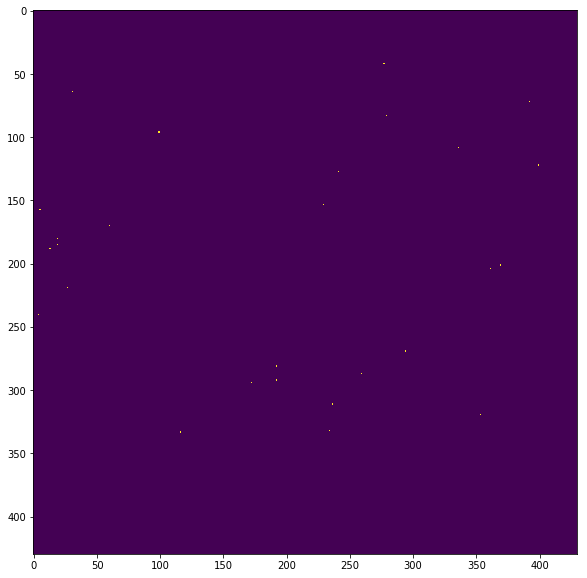

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(mask_tot_s-fr)

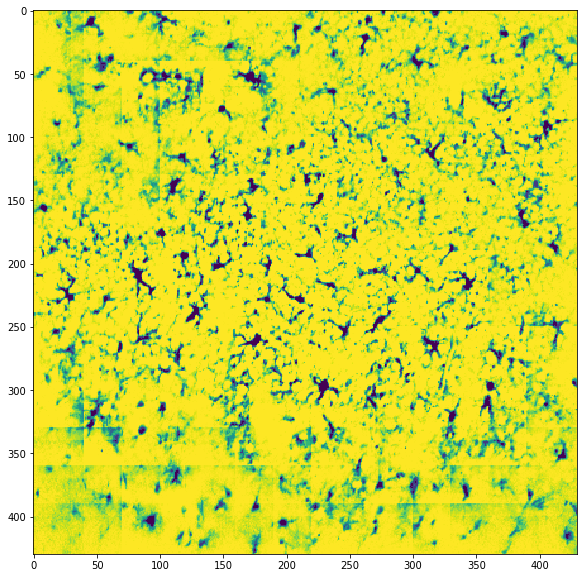

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(mapped-mapped2)

In [43]:
np.sum(mapped-mapped2)

-72573.75000000297